In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import pickle
from sklearn.metrics import *
import pandas as pd
import seaborn as sns
import statsmodels

In [2]:
from all_models import *
#from transfer_models import *

In [9]:
# read fit values
#fits_single = pickle.load(open('fit_single_CV_704.pickle', 'rb'))
#fits_dual = pickle.load(open('fit_dual_CV_704.pickle', 'rb'))
#fits_avg = pickle.load(open('fit_dual_fastavg_CV_704.pickle', 'rb'))
#fits_eight = pickle.load(open('fit_dual_eight_CV_704.pickle', 'rb'))
#fits_alpha = pickle.load(open('fit_dual_2alpha_CV_704.pickle', 'rb'))
#fits_six = pickle.load(open('fit_six_CV_704.pickle', 'rb'))
#fits_mixed = pickle.load(open('fit_mixed_CV_704.pickle', 'rb'))
fits_single = pickle.load(open('fit_single_704_ide.pickle', 'rb'))
fits_dual = pickle.load(open('fit_dual_704_ide.pickle', 'rb'))
fits_hybrid = pickle.load(open('fit_hybrid_CV_704.pickle', 'rb'))
#fits_single_transfer = pickle.load(open('fit_single_CV_transfer.pickle', 'rb'))
#fits_dual_transfer = pickle.load(open('fit_dual_CV_transfer.pickle', 'rb'))

curvatures_smooth = pickle.load(open('curvatures_smooth.pickle', 'rb'))
curvatures_smooth = curvatures_smooth/90.0
curvatures = pickle.load(open('curvatures.pickle', 'rb'))

In [10]:
curvatures_smooth = pickle.load(open('ide.pickle', 'rb'))


In [ ]:
for participant in range(60):
    np.nan_to_num(np.ravel(curvatures[participant][1:]), nan = np.nanmedian(curvatures[participant][1:]))

In [11]:
num_itr = 1

num_trials = 704
model_errors_dual = np.zeros((num_itr, 60, num_trials))
model_errors_single = np.zeros((num_itr, 60, num_trials))
model_errors_hybrid = np.zeros((num_itr, 60, num_trials))
#model_errors_dual_704 = np.zeros((num_itr, 60, 704))
#model_errors_single_704 = np.zeros((num_itr, 60, 704))
#model_errors_avg = np.zeros((num_itr, 60, 704))
#model_errors_eight = np.zeros((num_itr, 60, 704))
#model_errors_alpha = np.zeros((num_itr, 60, 704))

for i in range(num_itr):
    for participant in range(60):
        if participant%4 == 0 or participant%4 == 1:

            model_errors_dual[i][participant]  = dual_model_sudden(704, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[0]
            model_errors_single[i][participant] = model_sudden(704, fits_single[i][participant][0], fits_single[i][participant][1])[0]
        
        else:
            
            model_errors_dual[i][participant] = dual_model_gradual(num_trials, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[0]
            model_errors_single[i][participant] = model_gradual(num_trials, fits_single[i][participant][0], fits_single[i][participant][1])[0]
        model_errors_hybrid[i][participant] = fits_hybrid[i][participant][0]*model_errors_single[i][participant] + (1 - fits_hybrid[i][participant][0])*model_errors_dual[i][participant]


        

In [25]:
df_single_dual = pd.DataFrame({'Rotation_Estimate': np.ravel(np.concatenate([model_sudden(704, 1, 0.01)[1], dual_model_sudden(704, 0.9, 0.1, 1, 0.01)[1]])),

                               'Error':np.ravel(np.concatenate([model_sudden(704, 1, 0.01)[0],  dual_model_sudden(704, 0.9, 0.1, 1, 0.01)[0]])), 

                               'Trial': np.tile(range(704), 2),
                               'Model': np.repeat(['Single', 'Dual'], 704)
                              
                              })


In [12]:
ll_dual = np.zeros((num_itr, 60, num_trials))
ll_single = np.zeros((num_itr, 60, num_trials))
ll_hybrid = np.zeros((num_itr, 60, num_trials))

for i in range(num_itr):
    for participant in range(60):

        ll_dual[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_dual[i][participant], fits_dual[i][participant, -2])
        ll_single[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_single[i][participant], fits_single[i][participant, -2])
        ll_hybrid[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_hybrid[i][participant], fits_hybrid[i][participant, -2])
        
        #ll_alpha[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_alpha[i][participant], fits_alpha[i][participant, -2])
        
        #ll_mix[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_mixed[i][participant], fits_mixed[i][participant, -2])
        #ll_six[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_six[i][participant], fits_six[i][participant, -2])
        #ll_six[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_six[i][participant], fits_dual[i][participant, -2])

        #ll_dual_avg[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_avg[i][participant], fits_avg[i][participant, -2])
        #ll_eight[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_eight[i][participant], fits_eight[i][participant, -2])

In [13]:
def get_lls(fits, ll, rotate):
    ll_rotate_train = np.zeros((num_itr, 60))
    ll_transfer_train = np.zeros((num_itr, 60))
    ll_rotate_test = np.zeros((num_itr, 60))
    ll_transfer_test = np.zeros((num_itr, 60))
    ll_all_test = np.zeros((num_itr, 60))
    ll_all_train = np.zeros((num_itr, 60))

    for i in range(num_itr):
        for participant in range(60):
            rotate_train_indices = fits[i][participant, -1][fits[i][participant, -1] < 640]
            transfer_train_indices = fits[i][participant, -1][fits[i][participant, -1] >= 640]
            
            all_test_indices = np.delete(range(704), fits[i][participant, -1])
            rotate_test_indices = all_test_indices[all_test_indices<640]
            transfer_test_indices = all_test_indices[all_test_indices>=640]
            #if rotate:
            ll_rotate_train[i][participant] = sum(ll[i][participant][rotate_train_indices])
            ll_rotate_test[i][participant] = sum(ll[i][participant][rotate_test_indices])
            #else:
            ll_transfer_train[i][participant] = sum(ll[i][participant][transfer_train_indices])
            ll_transfer_test[i][participant] = sum(ll[i][participant][transfer_test_indices])
            #Uncomment for combined rotate + transfer
            ll_all_test[i][participant] = sum(ll[i][participant][all_test_indices])
            ll_all_train[i][participant] = sum(ll[i][participant][fits[i][participant, -1]])
    return [ll_rotate_train, ll_rotate_test, ll_transfer_train, ll_transfer_test, ll_all_train, ll_all_test]

In [14]:
dual_lls = get_lls(fits_dual, ll_dual, 0)
single_lls = get_lls(fits_single, ll_single, 0)
hybrid_lls = get_lls(fits_hybrid, ll_hybrid, 0)

#dual_lls = get_lls(fits_dual, ll_dual, 0)
#single_lls = get_lls(fits_single, ll_single, 0)
#alpha_lls = get_lls(fits_alpha, ll_alpha, 0)
#eight_lls = get_lls(fits_eight, ll_eight, 0)

In [15]:
def get_full_split_df(ll_selected, ll_compared, selected_model):
    d = {'Rotation': np.ravel(np.row_stack((np.repeat('Sudden', 120), np.repeat('Gradual', 120)))),
         'Emphasis': np.ravel(np.row_stack((np.repeat('Speed', 60), np.repeat('Accuracy', 60), np.repeat('Speed', 60), np.repeat('Accuracy', 60)))),
         'Phase': np.ravel(np.row_stack((np.repeat('Rotate', 30), np.repeat('Transfer', 30), np.repeat('Rotate', 30), np.repeat('Transfer', 30), np.repeat('Rotate', 30), np.repeat('Transfer', 30), np.repeat('Rotate', 30), np.repeat('Transfer', 30)))),
         'Set': np.ravel(np.row_stack((np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), (np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15)))))}
    df = pd.DataFrame(d)

    df[selected_model] = np.concatenate((
    sum(ll_compared[0][:, 0::4] <= ll_selected[0][:, 0::4]), 
    sum(ll_compared[1][:, 0::4] <= ll_selected[1][:, 0::4]),
    sum(ll_compared[2][:, 0::4] <= ll_selected[2][:, 0::4]),
    sum(ll_compared[3][:, 0::4] <= ll_selected[3][:, 0::4]),

    sum(ll_compared[0][:, 1::4] <= ll_selected[0][:, 1::4]), 
    sum(ll_compared[1][:, 1::4] <= ll_selected[1][:, 1::4]),
    sum(ll_compared[2][:, 1::4] <= ll_selected[2][:, 1::4]),
    sum(ll_compared[3][:, 1::4] <= ll_selected[3][:, 1::4]),

    sum(ll_compared[0][:, 2::4] <= ll_selected[0][:, 2::4]), 
    sum(ll_compared[1][:, 2::4] <= ll_selected[1][:, 2::4]),
    sum(ll_compared[2][:, 2::4] <= ll_selected[2][:, 2::4]),
    sum(ll_compared[3][:, 2::4] <= ll_selected[3][:, 2::4]),

    sum(ll_compared[0][:, 3::4] <= ll_selected[0][:, 3::4]), 
    sum(ll_compared[1][:, 3::4] <= ll_selected[1][:, 3::4]),
    sum(ll_compared[2][:, 3::4] <= ll_selected[2][:, 3::4]),
    sum(ll_compared[3][:, 3::4] <= ll_selected[3][:, 3::4])
    ))
    return df

In [16]:
def get_train_test_split(ll_selected, ll_compared, model_selected):
    d = {'Rotation': np.ravel(np.row_stack((np.repeat('Sudden', 60), np.repeat('Gradual', 60)))),
     'Emphasis': np.ravel(np.row_stack((np.repeat('Speed', 30), np.repeat('Accuracy', 30), np.repeat('Speed', 30), np.repeat('Accuracy', 30)))),
     'Set': np.ravel(np.row_stack((np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15))))}
    df = pd.DataFrame(d)
    df[model_selected] = np.concatenate((
    sum(ll_compared[4][:, 0::4] <= ll_selected[4][:, 0::4]), 
    sum(ll_compared[5][:, 0::4] <= ll_selected[5][:, 0::4]),

    sum(ll_compared[4][:, 1::4] <= ll_selected[4][:, 1::4]), 
    sum(ll_compared[5][:, 1::4] <= ll_selected[5][:, 1::4]),

    sum(ll_compared[4][:, 2::4] <= ll_selected[4][:, 2::4]), 
    sum(ll_compared[5][:, 2::4] <= ll_selected[5][:, 2::4]),

    sum(ll_compared[4][:, 3::4] <= ll_selected[4][:, 3::4]), 
    sum(ll_compared[5][:, 3::4] <= ll_selected[5][:, 3::4]),
    ))
    return df

In [19]:
df_full_split = get_full_split_df(dual_lls, single_lls, "Dual_Selected")
df_train_test = get_train_test_split(dual_lls, single_lls, "Dual_Selected")

Text(0.5, 0.98, 'Compared to Single')

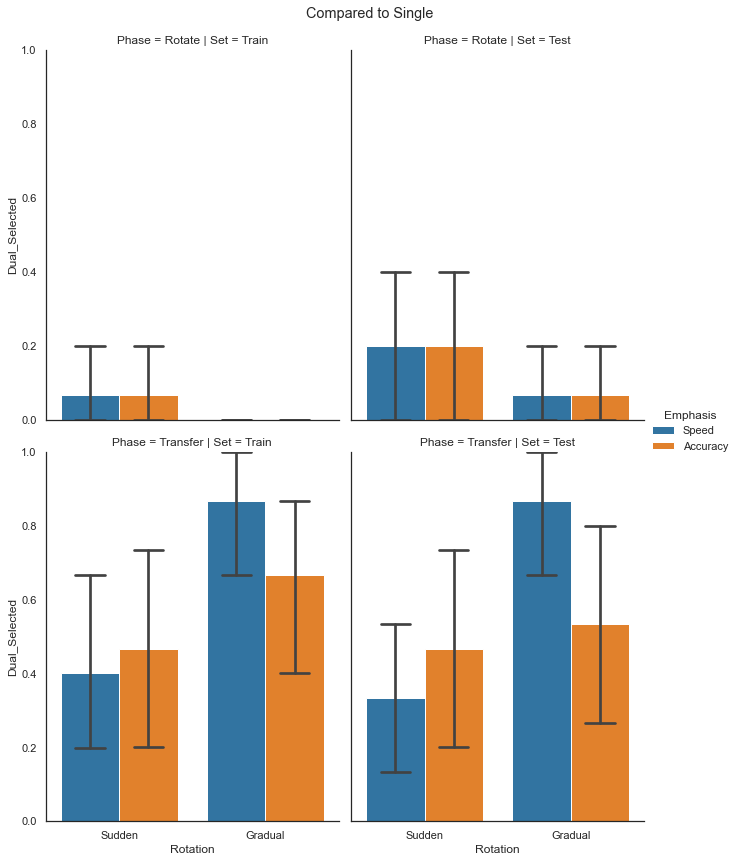

In [23]:
g = sns.catplot(x="Rotation", y="Dual_Selected", hue="Emphasis", col="Set", row = "Phase",
                capsize=.2, height=6, aspect=.75,ci = 95,
                kind = 'bar', data=df_full_split)
plt.subplots_adjust(top=0.93)
plt.ylim((0, num_itr))
g.fig.suptitle('Compared to Single')


Text(0.5, 0.98, 'Test Set : Compared to Single')

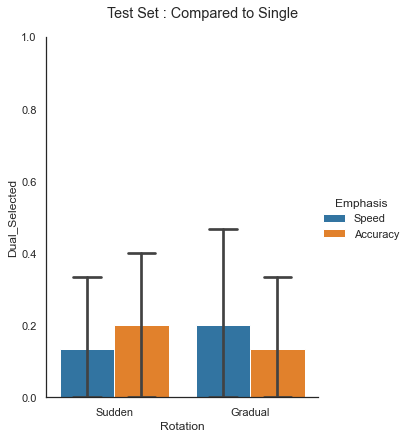

In [24]:
sns.set_context('notebook')
sns.set_style('white')
g = sns.catplot(x="Rotation", y="Dual_Selected", hue="Emphasis", 
                capsize=.2, height=6, aspect=.75,ci = 95,
                kind = 'bar', data=df_train_test[df_train_test['Set'] == 'Test'])
plt.subplots_adjust(top=0.91)
plt.ylim((0, 1))
g.fig.suptitle('Test Set : Compared to Single')

In [160]:
dual_selected_testset = df_train_test[df_train_test['Set'] == 'Test']
dual_selected_testset['Condition'] = dual_selected_testset['Rotation'] + '_' + dual_selected_testset['Emphasis']
dual_selected_testset = dual_selected_testset.reset_index()


<ipython-input-160-73818549006e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dual_selected_testset['Condition'] = dual_selected_testset['Rotation'] + '_' + dual_selected_testset['Emphasis']


In [161]:
errors = pd.read_csv('Curvature_Errors.csv')
errors['Condition'] = errors['Rotation'] + '_' + errors['Emphasis']
blockwise_errors = errors.groupby(['Participant_Id', 'Block', 'Rotation', 'Emphasis', 'Condition']).mean().reset_index()

In [167]:
dual_selected_80 = dual_selected_testset[dual_selected_testset['Dual_Selected'] >= 50].reset_index() 
dual_selected_80['Participant_Id'] = range(len(dual_selected_80))

dual_selected_80.loc[dual_selected_80['Condition'] =='Sudden_Speed', 'Participant_Id'] = dual_selected_80[dual_selected_80['Condition'] == 'Sudden_Speed']['level_0']*4
dual_selected_80.loc[dual_selected_80['Condition'] =='Sudden_Accuracy', 'Participant_Id'] = (dual_selected_80[dual_selected_80['Condition'] == 'Sudden_Accuracy']['level_0']-15)*4 + 1
dual_selected_80.loc[dual_selected_80['Condition'] =='Gradual_Speed', 'Participant_Id'] = (dual_selected_80[dual_selected_80['Condition'] == 'Gradual_Speed']['level_0']-30)*4 + 2
dual_selected_80.loc[dual_selected_80['Condition'] =='Gradual_Accuracy', 'Participant_Id'] = (dual_selected_80[dual_selected_80['Condition'] == 'Gradual_Accuracy']['level_0']-45)*4 + 3
dual_selected_80['Participant_Id'] = dual_selected_80['Participant_Id'].astype(int)

dual_selected_80 = dual_selected_80.set_index('Participant_Id')

dual_selected_80.sort_index(inplace=True)
dual_selected_80 = dual_selected_80.reset_index()
dual_selected_80

merged_dual = pd.merge(blockwise_errors, dual_selected_80, on = "Participant_Id", how = 'right')
merged_dual['Model_Selected'] = 'Dual_Selected'

In [168]:
dual_selected_testset = df_train_test[df_train_test['Set'] == 'Test']
dual_selected_testset['Condition'] = dual_selected_testset['Rotation'] + '_' + dual_selected_testset['Emphasis']
dual_selected_testset = dual_selected_testset.reset_index()


single_selected_80 = dual_selected_testset[dual_selected_testset['Dual_Selected'] < 50].reset_index() 
single_selected_80['Participant_Id'] = range(len(single_selected_80))

single_selected_80.loc[single_selected_80['Condition'] =='Sudden_Speed', 'Participant_Id'] = single_selected_80[single_selected_80['Condition'] == 'Sudden_Speed']['level_0']*4
single_selected_80.loc[single_selected_80['Condition'] =='Sudden_Accuracy', 'Participant_Id'] = (single_selected_80[single_selected_80['Condition'] == 'Sudden_Accuracy']['level_0']-15)*4 + 1
single_selected_80.loc[single_selected_80['Condition'] =='Gradual_Speed', 'Participant_Id'] = (single_selected_80[single_selected_80['Condition'] == 'Gradual_Speed']['level_0']-30)*4 + 2
single_selected_80.loc[single_selected_80['Condition'] =='Gradual_Accuracy', 'Participant_Id'] = (single_selected_80[single_selected_80['Condition'] == 'Gradual_Accuracy']['level_0']-45)*4 + 3
single_selected_80['Participant_Id'] = single_selected_80['Participant_Id'].astype(int)

single_selected_80 = single_selected_80.set_index('Participant_Id')

single_selected_80.sort_index(inplace=True)
single_selected_80 = single_selected_80.reset_index()
single_selected_80

merged_single = pd.merge(blockwise_errors, single_selected_80, on = "Participant_Id", how = 'right')
merged_single['Model_Selected'] = 'Single_Selected'

<ipython-input-168-46555469c101>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dual_selected_testset['Condition'] = dual_selected_testset['Rotation'] + '_' + dual_selected_testset['Emphasis']


In [169]:
conc = merged_dual.append(merged_single)

In [170]:
conc.to_csv('conc.csv')

In [11]:
conc = pd.read_csv('conc.csv')

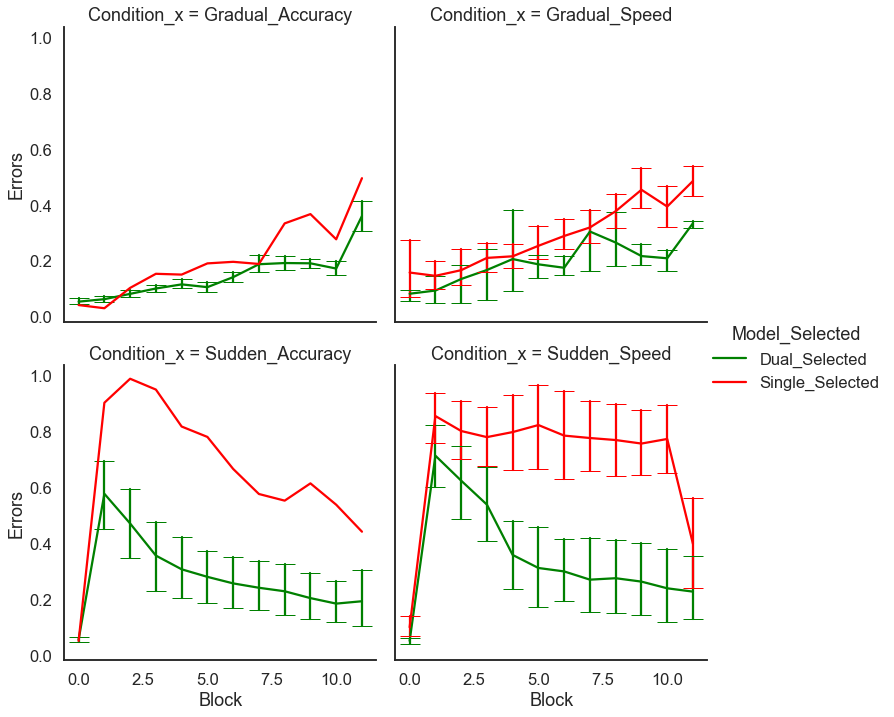

In [30]:
sns.set_context('talk')
sns.set_style('white')
sns.relplot(x = 'Block', y = 'Errors',  hue = 'Model_Selected', col = 'Condition_x', palette=['Green', 'Red'],
            kind = 'line', markers = True, err_style = 'bars', err_kws = {"capsize": 10}, 
             col_wrap=2, col_order=['Gradual_Accuracy', 'Gradual_Speed', 'Sudden_Accuracy', 'Sudden_Speed'], 
             data = conc)


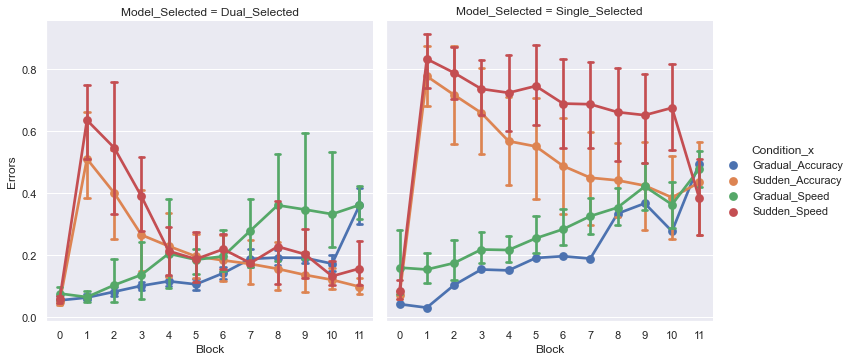

In [63]:
sns.catplot(x = 'Block', y = 'Errors', hue = 'Condition_x', kind = 'point', 
            capsize = 0.2, col = 'Model_Selected',
            data = conc)

In [34]:
model = smf.ols('Eight_Selected ~ Rotation*Emphasis', data=df_train_test[df_full_split['Set'] == 'Test']).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

<ipython-input-34-d1907dea8f1d>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  model = smf.ols('Eight_Selected ~ Rotation*Emphasis', data=df_train_test[df_full_split['Set'] == 'Test']).fit()


,sum_sq,df,F,PR(>F)
Rotation,375.000000,1.0,0.342537,0.560719
Emphasis,25297.066667,1.0,23.107167,0.000012
Rotation:Emphasis,2257.066667,1.0,2.061678,0.156606
Residual,61307.200000,56.0,NaN,NaN


In [23]:
SS = df_train_test['Dual_Selected'][df_train_test['Set'] == 'Test'][df_train_test['Emphasis'] == 'Speed'][df_train_test['Rotation'] == 'Sudden']
GS = df_train_test['Dual_Selected'][df_train_test['Set'] == 'Test'][df_train_test['Emphasis'] == 'Speed'][df_train_test['Rotation'] == 'Gradual']
SA = df_train_test['Dual_Selected'][df_train_test['Set'] == 'Test'][df_train_test['Emphasis'] == 'Accuracy'][df_train_test['Rotation'] == 'Sudden']
GA = df_train_test['Dual_Selected'][df_train_test['Set'] == 'Test'][df_train_test['Emphasis'] == 'Accuracy'][df_train_test['Rotation'] == 'Gradual']


In [24]:
statsmodels.stats.proportion.proportions_chisquare([np.mean(SS), np.mean(SG), np.mean(AS), np.mean(AG)],[100, 100, 100, 100])

NameError: name 'SG' is not defined

(-1.0, 1.0)

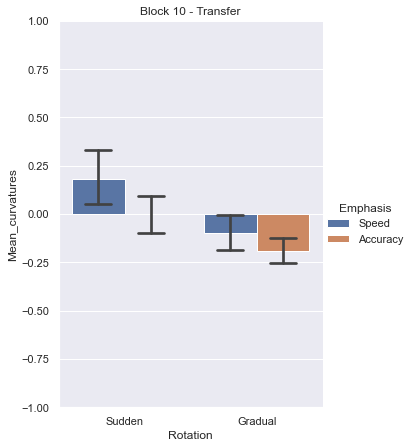

In [139]:
block = 11
d = {'Rotation': np.ravel(np.row_stack((np.repeat('Sudden', 30), np.repeat('Gradual', 30)))),
     'Emphasis': np.ravel(np.row_stack((np.repeat('Speed', 15), np.repeat('Accuracy', 15), np.repeat('Speed', 15), np.repeat('Accuracy', 15)))),
     
    'Mean_curvatures': np.concatenate((np.mean(curvatures_smooth[0::4], axis = 2)[:, block-1] - np.mean(curvatures_smooth[0::4], axis = 2)[:, block],
                np.mean(curvatures_smooth[1::4], axis = 2)[:, block-1] - np.mean(curvatures_smooth[1::4], axis = 2)[:, block],
                np.mean(curvatures_smooth[2::4], axis = 2)[:, block-1] - np.mean(curvatures_smooth[2::4], axis = 2)[:, block],
                np.mean(curvatures_smooth[3::4], axis = 2)[:, block-1] - np.mean(curvatures_smooth[3::4], axis = 2)[:, block],
             ))

    }

df_last_rotate = pd.DataFrame(d)
g = sns.catplot(x="Rotation", y="Mean_curvatures", hue="Emphasis",
                capsize=.2, height=6, aspect=.75,ci = 95,
                kind = 'bar', data=df_last_rotate)
plt.title('Block 10 - Transfer')
plt.ylim((-1, 1))

In [140]:
model = smf.ols('Mean_curvatures ~ Rotation*Emphasis', data=df_last_rotate).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Rotation,0.821691,1.0,18.930433,0.000058
Emphasis,0.282815,1.0,6.515604,0.013447
Rotation:Emphasis,0.031229,1.0,0.719476,0.399927
Residual,2.430727,56.0,NaN,NaN


In [95]:
np.mean(df_last_rotate['Mean_curvatures'][46:60])

-0.17998015909867204

In [151]:
a, b = stats.chisquare([GS, GA, SS, SA])

array([88.4       , 17.61643836, 70.19806763, 10.90797546, 32.59036145,
       54.28571429, 47.72151899, 11.47770701, 48.03971119,  9.67701863,
       29.75409836, 12.34680135, 17.83387622, 55.20216606, 26.39649123])

Text(0.5, 1.0, 'Rotate')

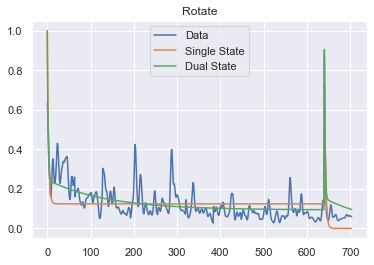

In [155]:
participant = 41
itr = 22
p0, = plt.plot(np.ravel(curvatures_smooth[participant][1:]))
p1, = plt.plot(model_errors_single[itr][participant])
p2, = plt.plot(model_errors_dual[itr][participant])
plt.legend((p0, p1, p2), ('Data', 'Single State', 'Dual State'))
plt.title('Rotate')

Text(0.5, 1.0, 'Transfer')

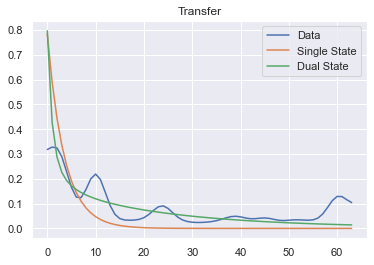

In [48]:
participant = 37

p0, = plt.plot(np.ravel(curvatures_smooth[participant][-1]))
p1, = plt.plot(np.mean(model_errors_single_transfer, axis = 0)[participant])
p2, = plt.plot(np.mean(model_errors_dual_transfer, axis = 0)[participant])

plt.legend((p0, p1, p2), ('Data', 'Single State', 'Dual State'))
plt.title('Transfer')

In [49]:
curvatures_smooth[participant][10][-1]

0.8514456500218309

In [32]:
participant = 53
fits_single_transfer[1][participant][2], fits_dual_transfer[1][participant][4]

(-16.286725535895798, -7.450671493772525)

In [38]:
participant = 14
-2*np.sum(stat.norm.logpdf(curvatures_smooth[participant][-1], model_errors_dual_transfer[0][participant]))

121.11122410290955

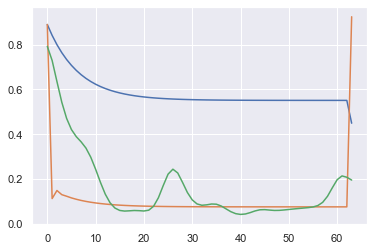

In [164]:
plt.plot(model_transfer(0.89, 64, 0.9210593053638314, 0.06433684145450244)[0])
plt.plot(dual_transfer(0.89, 64, 0.7135521829308, 0.49866691606443314, 0.9526619783821537, 0.4986667586384563,)[0])

plt.plot(curvatures_smooth[participant][-1])

In [158]:
1 - curvatures_smooth[participant][10][-1]

0.8995634881336975

In [117]:
its = pickle.load(open('params/its.pickle', 'rb'))
mts = pickle.load(open('mts.pickle', 'rb'))

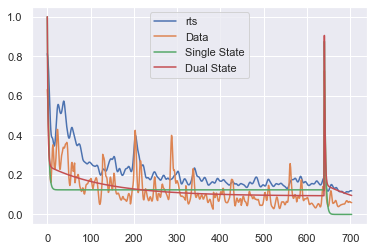

In [157]:
participant = 41
p, = plt.plot(gaussian_filter1d(np.ravel( (mts[participant][1:])/np.max(mts[participant]) + its[20][1:]/np.max(its[participant])), sigma = 3))
#plt.plot(np.ravel(curvatures_smooth[participant][1:]))
p0, = plt.plot(np.ravel(curvatures_smooth[participant][1:]))
p1, = plt.plot(model_errors_single[itr][participant])
p2, = plt.plot(model_errors_dual[itr][participant])
plt.legend((p, p0, p1, p2), ('rts', 'Data', 'Single State', 'Dual State'))


50.24349663838527

In [47]:
fits_dual[0, 5]

10.503401873917536

In [49]:
fits_single[0, 3]

-82.73038327528457

93.2337851492021